# Devign Function Call Pattern Analysis

In [45]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from pathlib import Path
from typing import List, Tuple
from tqdm import tqdm

## Function Call Distribution

In [71]:
DEVIGN_DIR = Path('raw_data/devign')
ACTION_LIST = [
    "summarize_code()",
    "list_variables()",
    "list_functions()",
    "list_freed_variables()",
    "list_null_assigned_variables()",
    "check_pattern(buffer_overflow)",
    "check_pattern('buffer_overflow')",
    "check_pattern(null_deref)",
    "check_pattern('null_deref')",
    "check_pattern(use_after_free)",
    "check_pattern('use_after_free')",
    "positive_alarm(<int line_number>)",
    "negative_alarm()",
]
func_cnt_dict = {}

def find_action(func_call):
    for action in ACTION_LIST:
        if action in func_call:
            if action == "check_pattern(buffer_overflow)" or action == "check_pattern('buffer_overflow')":
                return "check_pattern(buffer_overflow)"
            if action == "check_pattern(null_deref)" or action == "check_pattern('null_deref')":
                return "check_pattern(null_deref)"
            if action == "check_pattern(use_after_free)" or action == "check_pattern('use_after_free')":
                return "check_pattern(use_after_free)"
            return action
    return None

In [29]:
for model_dir in tqdm(os.listdir(DEVIGN_DIR)):
    if not os.path.isdir(DEVIGN_DIR / model_dir):
        continue
    
    model_id = model_dir.split('-')[0]
    for split_dir in os.listdir(DEVIGN_DIR / model_dir):
        if not os.path.isdir(DEVIGN_DIR / model_dir / split_dir):
            continue
        for file in os.listdir(DEVIGN_DIR / model_dir / split_dir):
            assert 'json' in file
            episode_id = int(file.split('_')[1].split('.')[0])
            with open(DEVIGN_DIR / model_dir / split_dir / file) as f:
                data = json.load(f)
                if 'trajectory' not in data or type(data['trajectory']) != dict:
                    continue # zero occurrence
                trajectory = data['trajectory']
                if 'done' not in trajectory or not trajectory['done']:
                    continue # zero occurrence
                
                for action_info in trajectory["state"]["processed_actions"]:
                    func_call, is_valid = action_info[0], action_info[1]
                    if "positive_alarm" in func_call or "negative_alarm" in func_call:
                        continue
                    action = find_action(func_call)
                    if not action: # action not found
                        continue
                    if action in func_cnt_dict:
                        if is_valid == "VALID":
                            func_cnt_dict[action]["valid"] += 1
                        else:
                            func_cnt_dict[action]["invalid"] += 1
                    else:
                        func_cnt_dict[action] = {"valid": 0, "invalid": 0}
                        if is_valid == "VALID":
                            func_cnt_dict[action]["valid"] += 1
                        else:
                            func_cnt_dict[action]["invalid"] += 1



100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


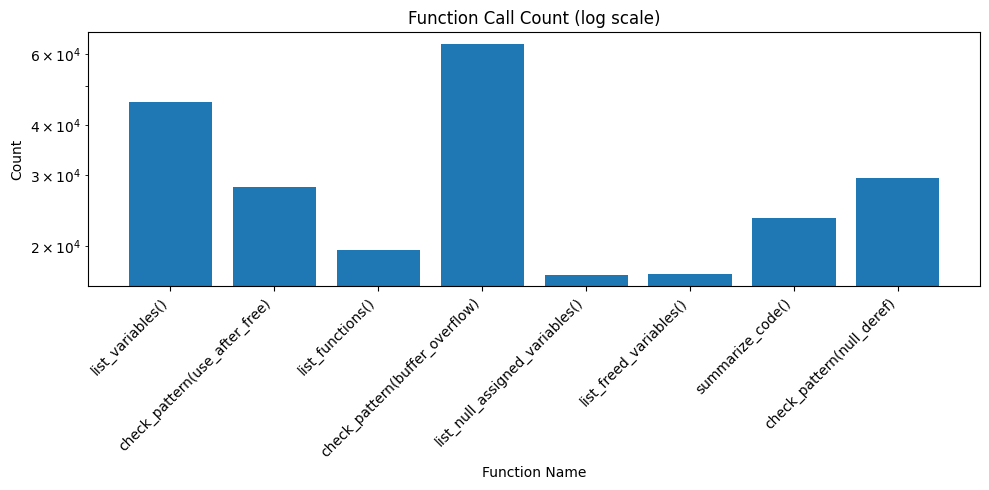

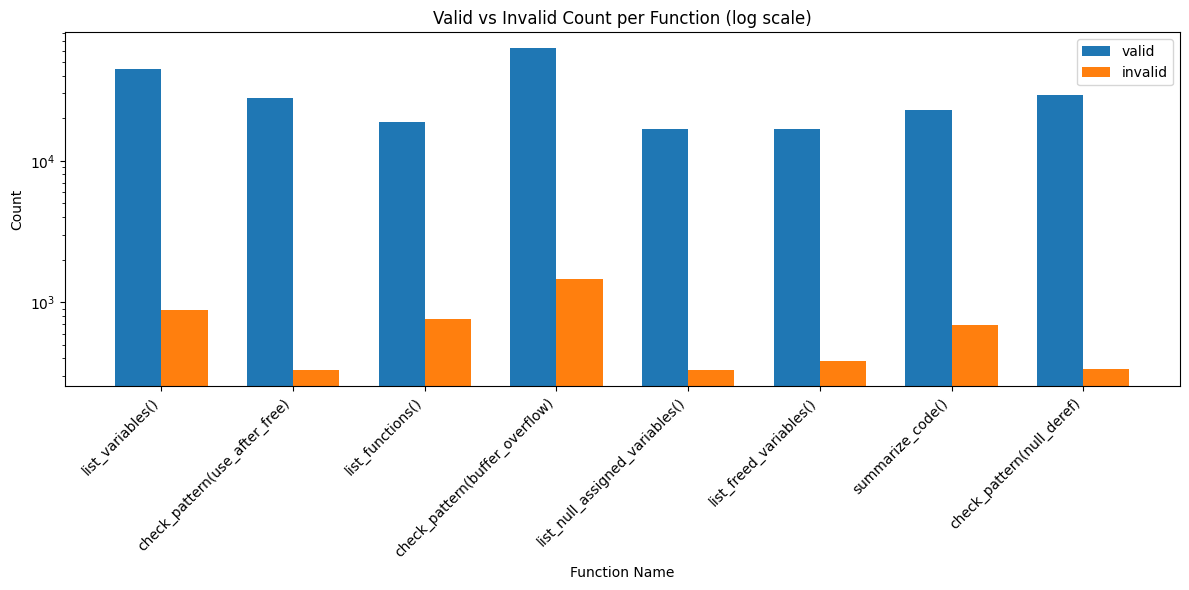

In [31]:
def plot_dict(data, split=False):
    # 함수 이름과 카운트를 분리
    keys = list(data.keys())
    if not split:
        values = [e["valid"] + e["invalid"] for e in data.values()]
    

    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))

    # 막대그래프 그리기
    plt.bar(keys, values)

    # 라벨과 제목 설정
    plt.xlabel("Function Name")
    plt.ylabel("Count")
    plt.title("Function Call Count (log scale)")

    # x축 라벨이 겹치지 않도록 회전
    plt.xticks(rotation=45, ha="right")
    plt.yscale("log")
    # 그래프 표시
    plt.tight_layout()
    plt.show()

def plot_valid_invalid(data):
    func_names = list(data.keys())
    valid_counts = [data[f]["valid"] for f in func_names]
    invalid_counts = [data[f]["invalid"] for f in func_names]

    x = np.arange(len(func_names))  # x축 위치
    width = 0.35  # 막대 너비

    plt.figure(figsize=(12, 6))

    # valid / invalid 막대를 나란히 배치
    plt.bar(x - width/2, valid_counts, width, label="valid")
    plt.bar(x + width/2, invalid_counts, width, label="invalid")

    plt.xticks(x, func_names, rotation=45, ha="right")
    plt.xlabel("Function Name")
    plt.yscale("log")
    plt.ylabel("Count")
    plt.title("Valid vs Invalid Count per Function (log scale)")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_dict(func_cnt_dict)
plot_valid_invalid(func_cnt_dict)

## 4-gram Analysis without Validity

In [78]:
def extract_function_call_sequence(action_list):
    """
    Extract the sequence of roles from messages.

    Args:
        messages: List of message dictionaries

    Returns:
        List of role strings in order
    """
    sequence = []
    for action_info in action_list:
        func_call = action_info[0]
        if "positive_alarm" in func_call or "negative_alarm" in func_call:
            continue
        action = find_action(func_call)
        if action:
            sequence.append(action)
    return sequence

def extract_function_call_sequence_with_validity(action_list):
    """
    Extract the sequence of roles from messages.

    Args:
        messages: List of message dictionaries

    Returns:
        List of role strings in order
    """
    sequence = []
    for action_info in action_list:
        func_call, is_valid = action_info[0], action_info[1]
        if "positive_alarm" in func_call or "negative_alarm" in func_call:
            continue
        action = find_action(func_call)
        if action:
            if is_valid == "VALID":
                action = action + "_valid"
            else:
                action = action + "_invalid"
            sequence.append(action)
    return sequence


def get_4grams(sequence: List[str]) -> List[Tuple[str, str, str, str]]:
    """
    Extract all 4-grams from a sequence.

    Args:
        sequence: List of items

    Returns:
        List of 4-gram tuples
    """
    four_grams = []
    for i in range(len(sequence) - 3):
        four_gram = tuple(sequence[i:i+4])
        four_grams.append(four_gram)
    return four_grams


def get_4grams_for_all_executions_in_directory(directory_path, with_validity=False):
    """
    Process all JSON files in a directory and extract 4-grams.

    Args:
        directory_path: Path to directory containing JSON files

    Returns:
        List of all 4-grams found
    """
    all_4grams = []


    for json_file in directory_path.glob("*.json"):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)

            if 'trajectory' not in data or type(data['trajectory']) != dict:
                continue # zero occurrence
            trajectory = data['trajectory']
            if 'done' not in trajectory or not trajectory['done']:
                continue # zero occurrence
            if not "reward" in trajectory:
                continue
            if not with_validity:
                sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
            if with_validity:
                sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
            # print(sequence)
            four_grams = get_4grams(sequence)
            all_4grams.extend(four_grams)
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

    return all_4grams

def get_4grams_for_successful_executions_in_directory(directory_path, with_validity=False):
    """
    Process all JSON files in a directory and extract 4-grams.

    Args:
        directory_path: Path to directory containing JSON files

    Returns:
        List of all 4-grams found
    """
    all_4grams = []


    for json_file in directory_path.glob("*.json"):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if 'trajectory' not in data or type(data['trajectory']) != dict:
                continue # zero occurrence
            trajectory = data['trajectory']
            if 'done' not in trajectory or not trajectory['done']:
                continue # zero occurrence
                
            if not "reward" in trajectory or trajectory["reward"] == 0:
                continue
            if not with_validity:
                sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
            if with_validity:
                sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
            four_grams = get_4grams(sequence)
            all_4grams.extend(four_grams)
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

    return all_4grams

def get_4grams_for_failing_executions_in_directory(directory_path, with_validity=False):
    """
    Process all JSON files in a directory and extract 4-grams.

    Args:
        directory_path: Path to directory containing JSON files

    Returns:
        List of all 4-grams found
    """
    all_4grams = []


    for json_file in directory_path.glob("*.json"):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if 'trajectory' not in data or type(data['trajectory']) != dict:
                continue # zero occurrence
            trajectory = data['trajectory']
            if 'done' not in trajectory or not trajectory['done']:
                continue # zero occurrence
                
            if not "reward" in trajectory or trajectory["reward"] == 1:
                continue
            
            if not with_validity:
                sequence = extract_function_call_sequence(trajectory["state"]["processed_actions"])
            if with_validity:
                sequence = extract_function_call_sequence_with_validity(trajectory["state"]["processed_actions"])
            four_grams = get_4grams(sequence)
            all_4grams.extend(four_grams)
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

    return all_4grams

In [86]:
def get_4grams_for_all_executions(model, with_validity=False):
    all_4grams = []
    for split_dir in os.listdir(DEVIGN_DIR / model):
        if not os.path.isdir(DEVIGN_DIR / model / split_dir):
            continue
            
        path = DEVIGN_DIR / model / split_dir

        if path.exists():
            four_grams = get_4grams_for_all_executions_in_directory(path, with_validity=with_validity)
            all_4grams.extend(four_grams)
        else:
            print(f"Warning: {file} does not exist")

    print(f"\nTotal 4-grams collected: {len(all_4grams)}")

    return all_4grams

def get_4grams_for_success_executions(model, with_validity=False):
    all_4grams = []
    for split_dir in os.listdir(DEVIGN_DIR / model):
        if not os.path.isdir(DEVIGN_DIR / model / split_dir):
            continue
            
        path = DEVIGN_DIR / model / split_dir

        if path.exists():
            four_grams = get_4grams_for_successful_executions_in_directory(path, with_validity=with_validity)
            all_4grams.extend(four_grams)
        else:
            print(f"Warning: {path} does not exist")

    print(f"\nTotal 4-grams collected: {len(all_4grams)}")

    return all_4grams

def get_4grams_for_fail_executions(model, with_validity=False):
    all_4grams = []
    for split_dir in os.listdir(DEVIGN_DIR / model):
        if not os.path.isdir(DEVIGN_DIR / model / split_dir):
            continue
            
        path = DEVIGN_DIR / model / split_dir

        if path.exists():
            four_grams = get_4grams_for_failing_executions_in_directory(path, with_validity=with_validity)
            all_4grams.extend(four_grams)
        else:
            print(f"Warning: {path} does not exist")

    print(f"\nTotal 4-grams collected: {len(all_4grams)}")

    return all_4grams

In [93]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_4grams = get_4grams_for_all_executions(model)

    all_counter = Counter(all_4grams)

    results = []
    for four_gram, count in all_counter.most_common():
        results.append({
            '4gram': four_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./4gram_frequency/devign/without_validity/all_executions", exist_ok=True)
    output_file = f"./4gram_frequency/devign/without_validity/all_executions/{model}_4gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique 4-gram")


Total 4-grams collected: 3762
Saved ./4gram_frequency/devign/without_validity/all_executions/gemma3-4b_4gram_frequencies.csv with 399 unique 4-gram

Total 4-grams collected: 60359
Saved ./4gram_frequency/devign/without_validity/all_executions/llama3_1-8b_4gram_frequencies.csv with 2363 unique 4-gram

Total 4-grams collected: 25771
Saved ./4gram_frequency/devign/without_validity/all_executions/llama3_2-3b_4gram_frequencies.csv with 1947 unique 4-gram

Total 4-grams collected: 64828
Saved ./4gram_frequency/devign/without_validity/all_executions/mistral-7b_4gram_frequencies.csv with 2674 unique 4-gram


In [94]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_4grams = get_4grams_for_success_executions(model)

    all_counter = Counter(all_4grams)

    results = []
    for four_gram, count in all_counter.most_common():
        results.append({
            '4gram': four_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./4gram_frequency/devign/without_validity/success_executions", exist_ok=True)
    output_file = f"./4gram_frequency/devign/without_validity/success_executions/{model}_4gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique 4-gram")


Total 4-grams collected: 1692
Saved ./4gram_frequency/devign/without_validity/success_executions/gemma3-4b_4gram_frequencies.csv with 273 unique 4-gram

Total 4-grams collected: 29563
Saved ./4gram_frequency/devign/without_validity/success_executions/llama3_1-8b_4gram_frequencies.csv with 2050 unique 4-gram

Total 4-grams collected: 11643
Saved ./4gram_frequency/devign/without_validity/success_executions/llama3_2-3b_4gram_frequencies.csv with 1630 unique 4-gram

Total 4-grams collected: 33639
Saved ./4gram_frequency/devign/without_validity/success_executions/mistral-7b_4gram_frequencies.csv with 2300 unique 4-gram


In [95]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_4grams = get_4grams_for_fail_executions(model)

    all_counter = Counter(all_4grams)

    results = []
    for four_gram, count in all_counter.most_common():
        results.append({
            '4gram': four_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./4gram_frequency/devign/without_validity/fail_executions", exist_ok=True)
    output_file = f"./4gram_frequency/devign/without_validity/fail_executions/{model}_4gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique 4-gram")


Total 4-grams collected: 2070
Saved ./4gram_frequency/devign/without_validity/fail_executions/gemma3-4b_4gram_frequencies.csv with 304 unique 4-gram

Total 4-grams collected: 30796
Saved ./4gram_frequency/devign/without_validity/fail_executions/llama3_1-8b_4gram_frequencies.csv with 2078 unique 4-gram

Total 4-grams collected: 14128
Saved ./4gram_frequency/devign/without_validity/fail_executions/llama3_2-3b_4gram_frequencies.csv with 1751 unique 4-gram

Total 4-grams collected: 31189
Saved ./4gram_frequency/devign/without_validity/fail_executions/mistral-7b_4gram_frequencies.csv with 2220 unique 4-gram



Model: gemma3-4b


Total 4-grams collected: 3762

Total 4-grams collected: 1692

Total 4-grams collected: 2070
                                                                                         pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
    check_use_after_free -> check_use_after_free -> check_use_after_free -> check_use_after_free             561                 224              337         39.9%      60.1%
                  list_vars -> check_buffer_overflow -> check_null_deref -> check_use_after_free             224                  91              133         40.6%      59.4%
                             list_vars -> check_buffer_overflow -> check_null_deref -> summarize             141                  62               79         44.0%      56.0%
                  list_vars -> check_null_deref -> check_use_after_free -> check_buffer_overflow             122                  63               59         51.6%      48.4%
             

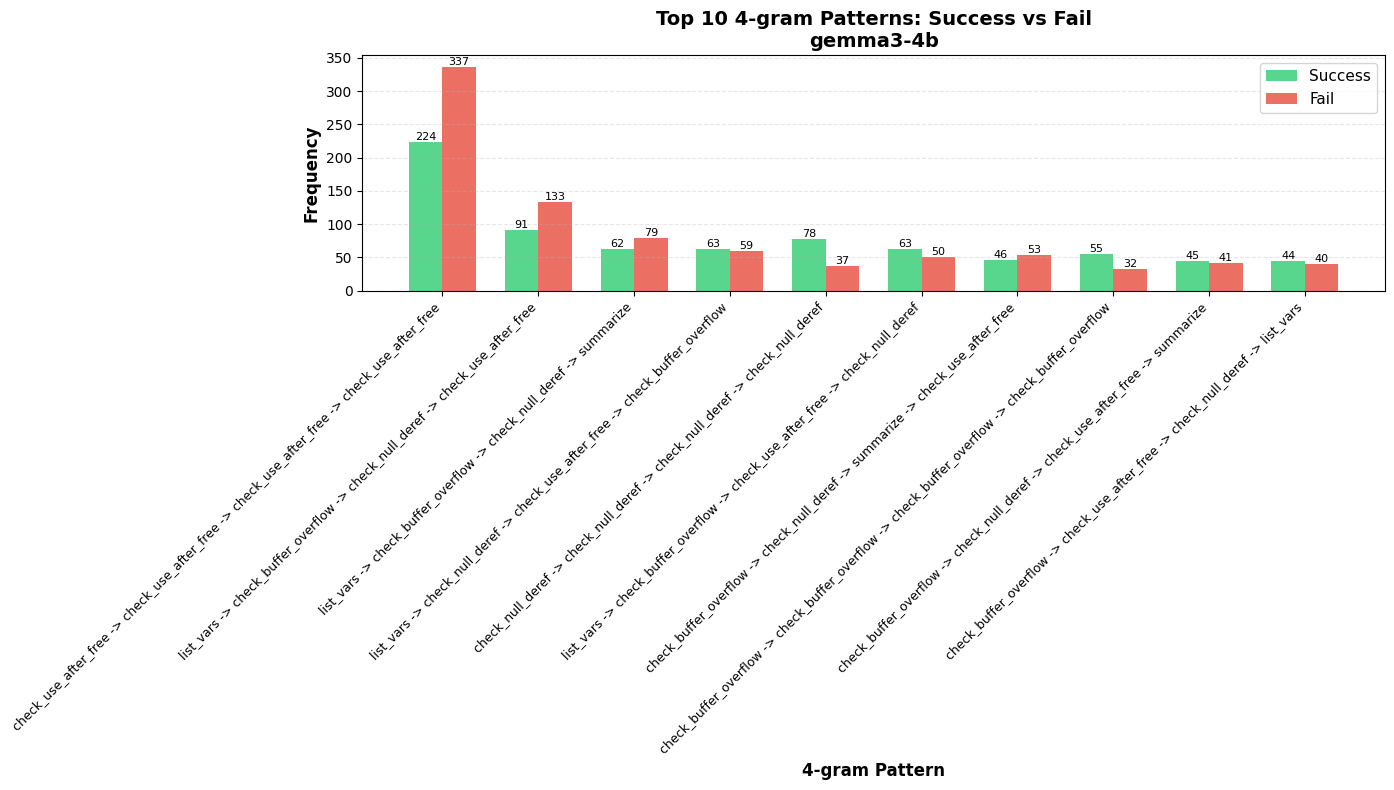


Model: llama3_1-8b


Total 4-grams collected: 60359

Total 4-grams collected: 29563

Total 4-grams collected: 30796
                                                                                         pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
check_buffer_overflow -> check_buffer_overflow -> check_buffer_overflow -> check_buffer_overflow             656                 362              294         55.2%      44.8%
                                   check_buffer_overflow -> summarize -> list_vars -> list_funcs             565                 267              298         47.3%      52.7%
                    check_null_deref -> check_null_deref -> check_null_deref -> check_null_deref             537                 336              201         62.6%      37.4%
                             check_buffer_overflow -> check_null_deref -> summarize -> list_vars             447                 208              239         46.5%      53.5%
        

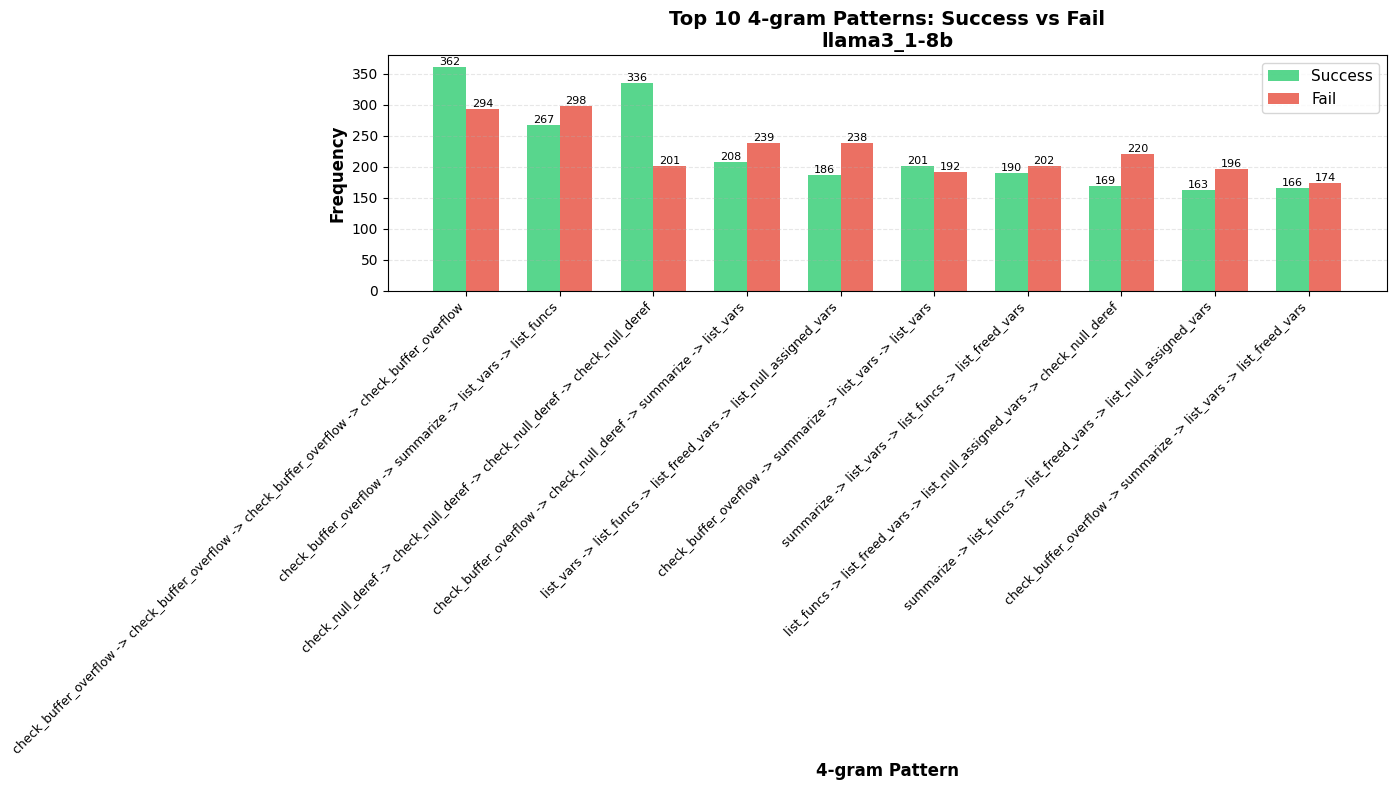


Model: llama3_2-3b


Total 4-grams collected: 25771

Total 4-grams collected: 11643

Total 4-grams collected: 14128
                                                                       pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
check_buffer_overflow -> list_vars -> check_use_after_free -> check_null_deref             255                 129              126         50.6%      49.4%
list_vars -> check_buffer_overflow -> check_use_after_free -> check_null_deref             253                 107              146         42.3%      57.7%
list_vars -> check_buffer_overflow -> check_null_deref -> check_use_after_free             241                 117              124         48.5%      51.5%
check_buffer_overflow -> list_vars -> check_null_deref -> check_use_after_free             234                 105              129         44.9%      55.1%
           list_vars -> check_buffer_overflow -> list_freed_vars -> list_funcs             179    

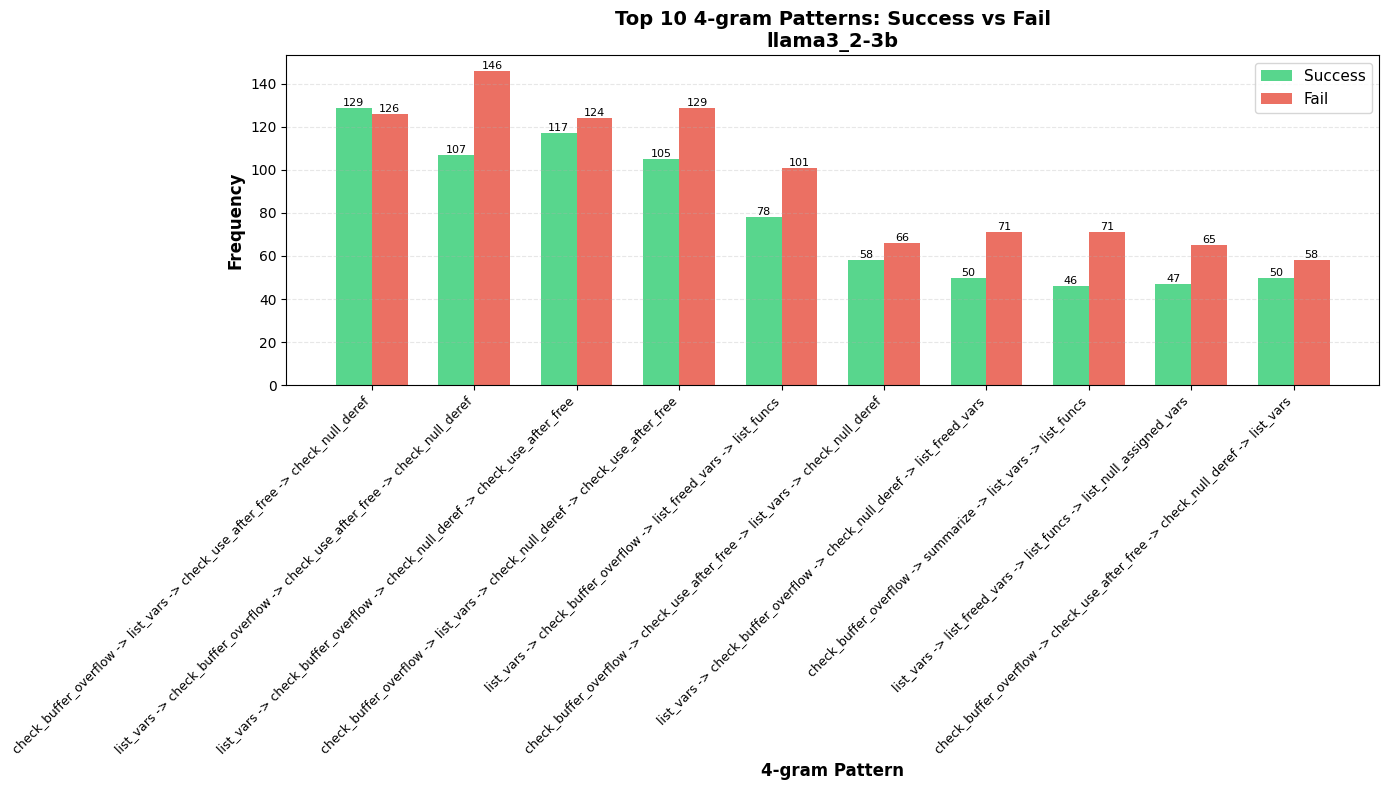


Model: mistral-7b


Total 4-grams collected: 64828

Total 4-grams collected: 33639

Total 4-grams collected: 31189
                                                                                           pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
  check_buffer_overflow -> check_buffer_overflow -> check_buffer_overflow -> check_buffer_overflow           11580                6321             5259         54.6%      45.4%
                                                  list_vars -> list_vars -> list_vars -> list_vars            3042                1638             1404         53.8%      46.2%
      check_use_after_free -> check_use_after_free -> check_use_after_free -> check_use_after_free            2568                1341             1227         52.2%      47.8%
              list_vars -> check_buffer_overflow -> check_buffer_overflow -> check_buffer_overflow            1327                 733              594         55.2%      44.8%

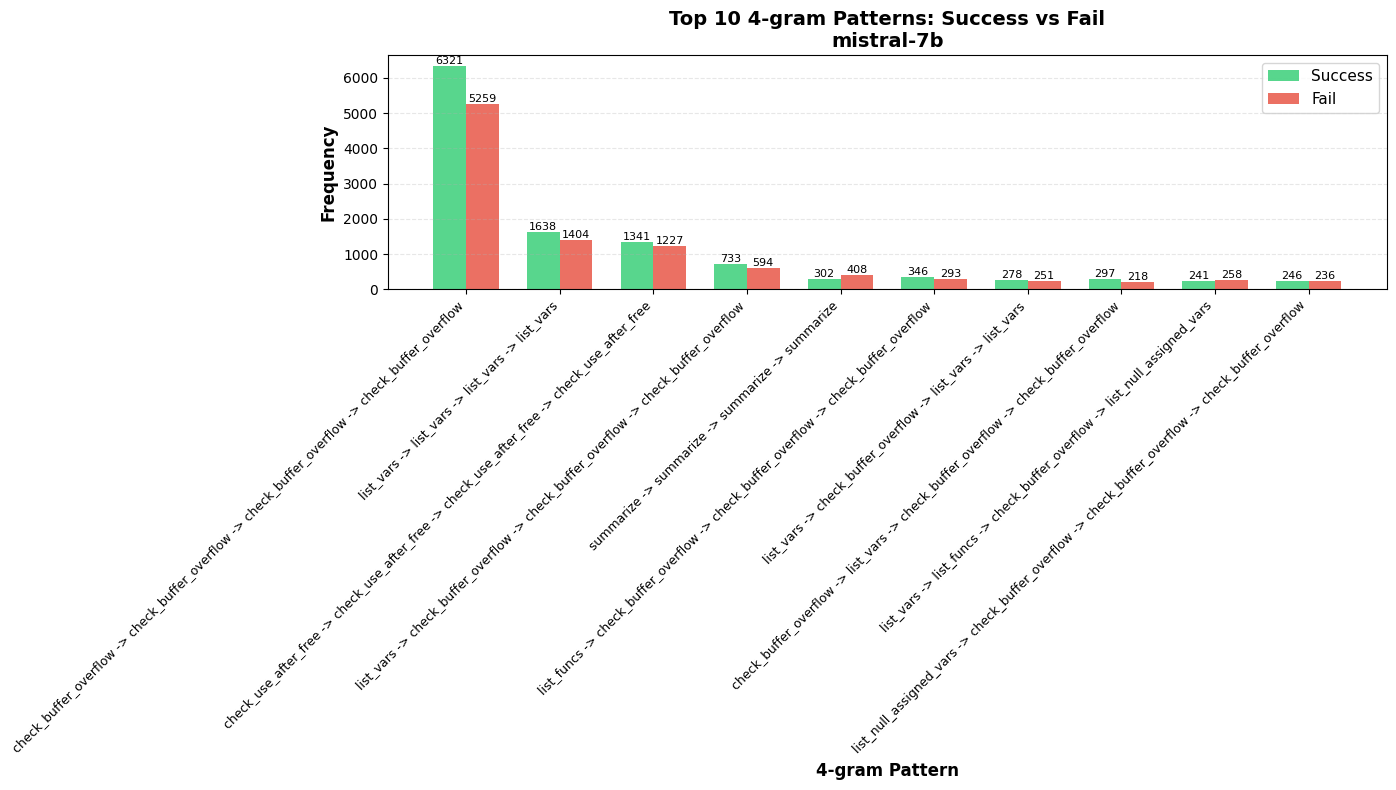

In [83]:
# Compare top 10 most frequent 4-grams in all executions vs success/fail executions

import matplotlib.pyplot as plt
import numpy as np

name_mapping = {
    "summarize_code()": "summarize",
    "list_variables()": "list_vars",
    "list_functions()": "list_funcs",
    "list_freed_variables()": "list_freed_vars",
    "list_null_assigned_variables()": "list_null_assigned_vars",
    "check_pattern(buffer_overflow)": "check_buffer_overflow",
    "check_pattern(null_deref)": "check_null_deref",
    "check_pattern(use_after_free)": "check_use_after_free",
}


def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])

# For each benchmark and model combination
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_4grams = get_4grams_for_all_executions(model)
    success_4grams = get_4grams_for_success_executions(model)
    fail_4grams = get_4grams_for_fail_executions(model)
    
    all_counter = Counter(all_4grams)
    success_counter = Counter(success_4grams)
    fail_counter = Counter(fail_4grams)
    
    # Get top 10 from all executions
    top_10_patterns = [pattern for pattern, count in all_counter.most_common(10)]
    
    # Create comparison table
    comparison_data = []
    for pattern in top_10_patterns:
        all_count = all_counter[pattern]
        success_count = success_counter[pattern]
        fail_count = fail_counter[pattern]
        
        comparison_data.append({
            'pattern': shorten_pattern(pattern),
            'all_executions': all_count,
            'success_executions': success_count,
            'fail_executions': fail_count,
            'success_ratio': f"{success_count/all_count*100:.1f}%" if all_count > 0 else "0%",
            'fail_ratio': f"{fail_count/all_count*100:.1f}%" if all_count > 0 else "0%"
        })
    
    # Display as DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print()
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    patterns = comparison_df['pattern'].tolist()
    success_counts = comparison_df['success_executions'].tolist()
    fail_counts = comparison_df['fail_executions'].tolist()
    
    x = np.arange(len(patterns))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, success_counts, width, label='Success', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, fail_counts, width, label='Fail', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('4-gram Pattern', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 10 4-gram Patterns: Success vs Fail\n{model}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(patterns, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


Model: gemma3-4b


Total 4-grams collected: 3762

Total 4-grams collected: 1692

Total 4-grams collected: 2070


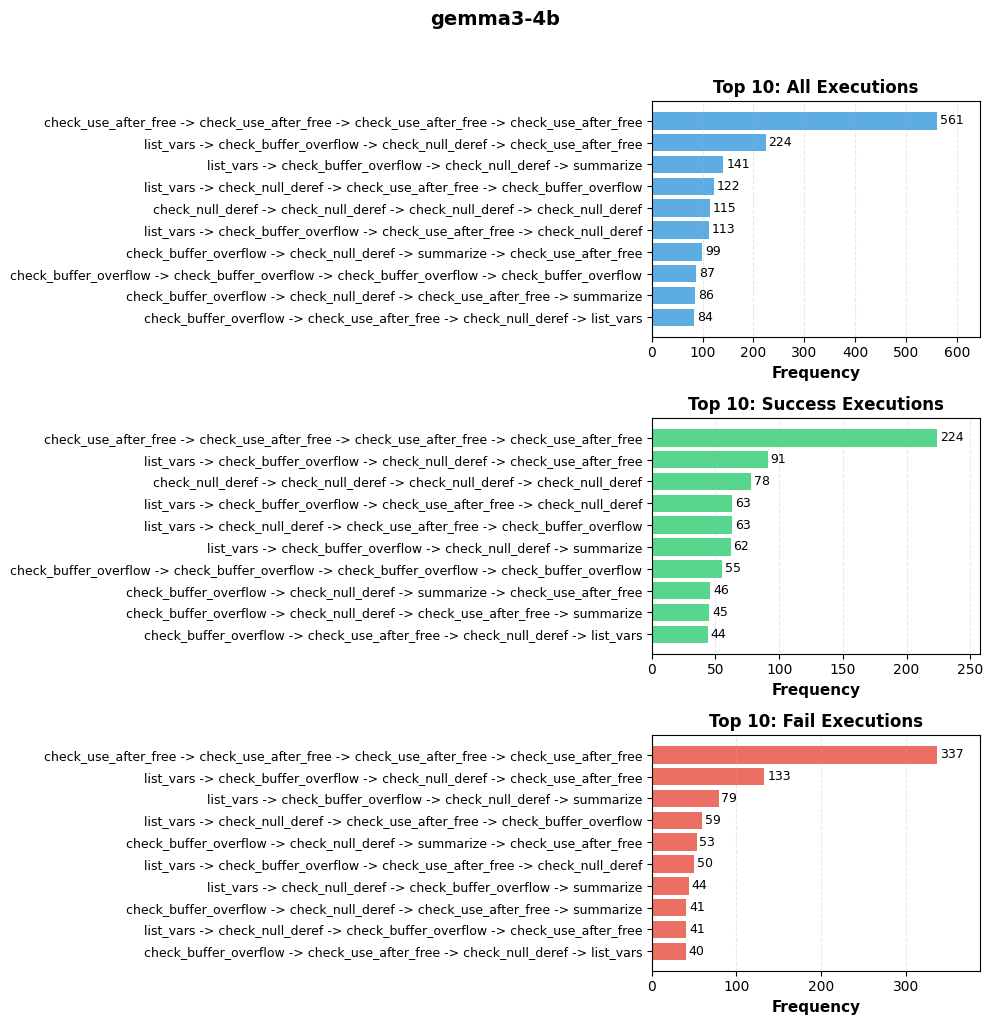


Model: llama3_1-8b


Total 4-grams collected: 60359

Total 4-grams collected: 29563

Total 4-grams collected: 30796


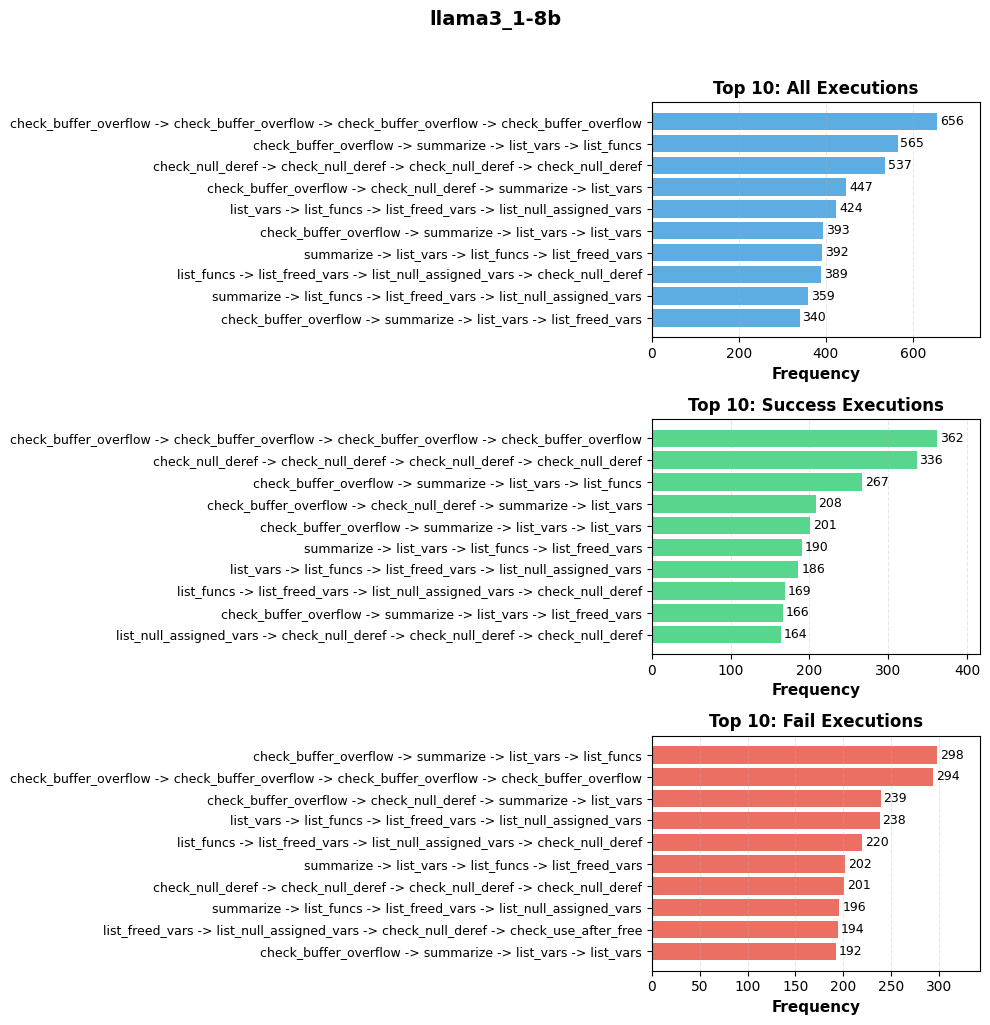


Model: llama3_2-3b


Total 4-grams collected: 25771

Total 4-grams collected: 11643

Total 4-grams collected: 14128


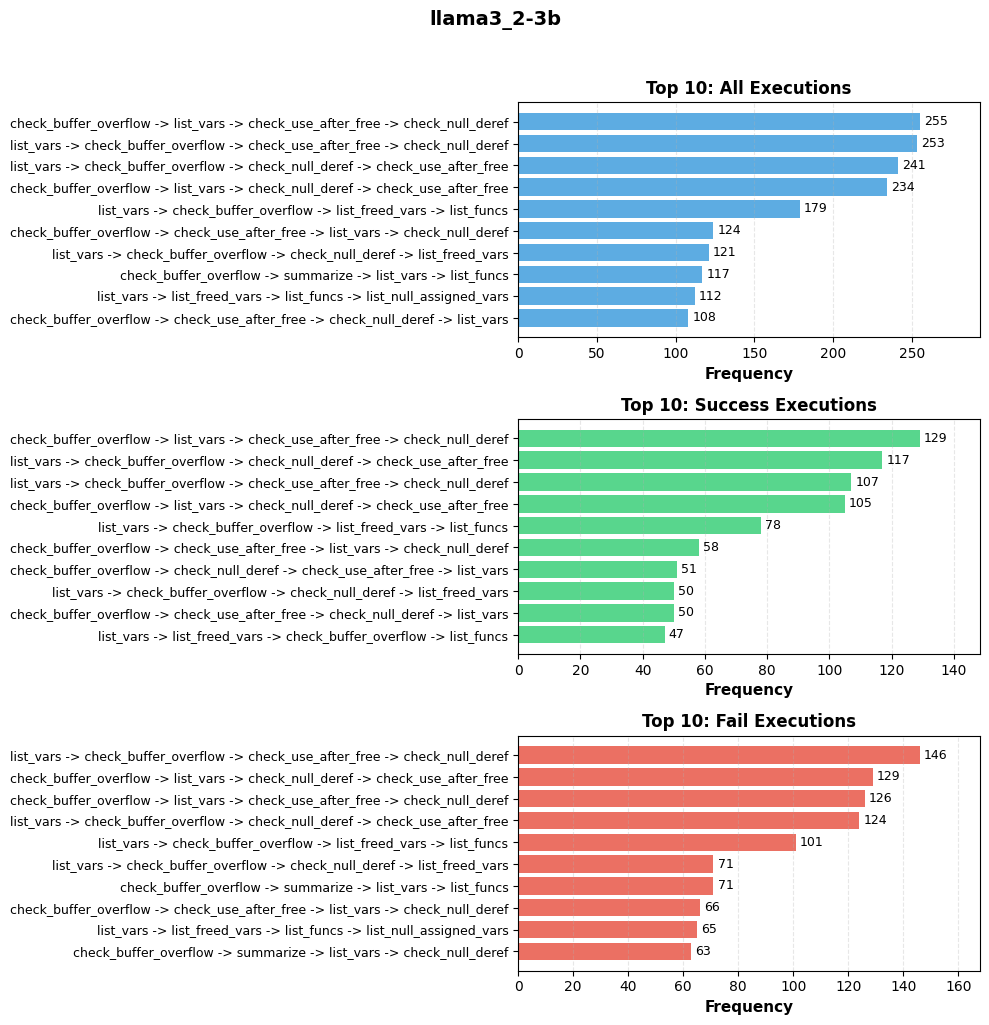


Model: mistral-7b


Total 4-grams collected: 64828

Total 4-grams collected: 33639

Total 4-grams collected: 31189


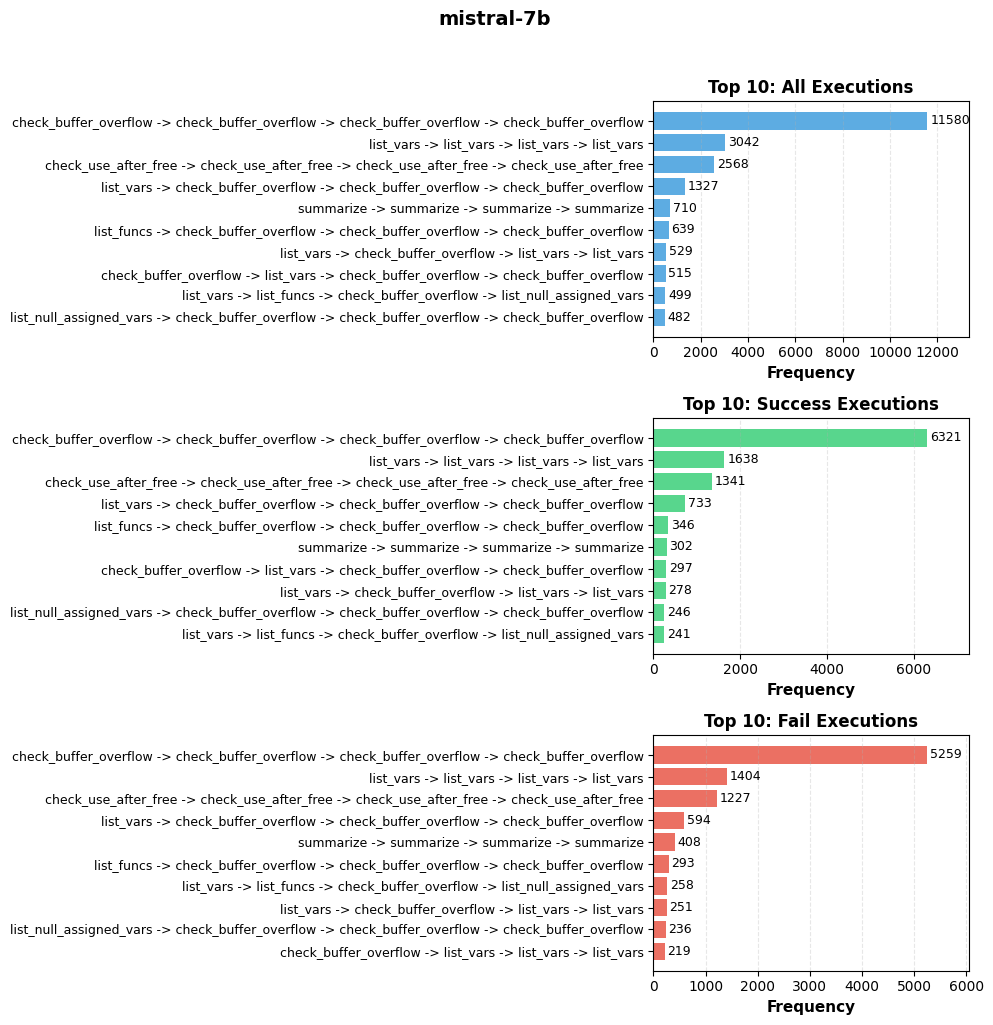

In [84]:
# Visualize Top 10 patterns separately for all/success/fail executions


for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_4grams = get_4grams_for_all_executions(model)
    success_4grams = get_4grams_for_success_executions(model)
    fail_4grams = get_4grams_for_fail_executions(model)
    
    all_counter = Counter(all_4grams)
    success_counter = Counter(success_4grams)
    fail_counter = Counter(fail_4grams)
    
    # Get top 10 from each counter
    top_10_all = [(shorten_pattern(pattern), count) for pattern, count in all_counter.most_common(10)]
    top_10_success = [(shorten_pattern(pattern), count) for pattern, count in success_counter.most_common(10)]
    top_10_fail = [(shorten_pattern(pattern), count) for pattern, count in fail_counter.most_common(10)]
    
    # Create 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))
    
    # Plot 1: All Executions
    patterns_all = [p[0] for p in top_10_all]
    counts_all = [p[1] for p in top_10_all]
    
    axes[0].barh(range(len(patterns_all)), counts_all, color='#3498db', alpha=0.8)
    axes[0].set_yticks(range(len(patterns_all)))
    axes[0].set_yticklabels(patterns_all, fontsize=9)
    axes[0].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title('Top 10: All Executions', fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3, linestyle='--')

    axes[0].set_xlim(0, max(counts_all)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_all):
        axes[0].text(v + max(counts_all)*0.01, i, str(v), va='center', fontsize=9)
    
    # Plot 2: Success Executions
    patterns_success = [p[0] for p in top_10_success]
    counts_success = [p[1] for p in top_10_success]
    
    axes[1].barh(range(len(patterns_success)), counts_success, color='#2ecc71', alpha=0.8)
    axes[1].set_yticks(range(len(patterns_success)))
    axes[1].set_yticklabels(patterns_success, fontsize=9)
    axes[1].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('Top 10: Success Executions', fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')

    axes[1].set_xlim(0, max(counts_success)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_success):
        axes[1].text(v + max(counts_success)*0.01, i, str(v), va='center', fontsize=9)
    
    # Plot 3: Fail Executions
    patterns_fail = [p[0] for p in top_10_fail]
    counts_fail = [p[1] for p in top_10_fail]
    
    axes[2].barh(range(len(patterns_fail)), counts_fail, color='#e74c3c', alpha=0.8)
    axes[2].set_yticks(range(len(patterns_fail)))
    axes[2].set_yticklabels(patterns_fail, fontsize=9)
    axes[2].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[2].set_title('Top 10: Fail Executions', fontsize=12, fontweight='bold')
    axes[2].invert_yaxis()
    axes[2].grid(axis='x', alpha=0.3, linestyle='--')

    axes[2].set_xlim(0, max(counts_fail)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_fail):
        axes[2].text(v + max(counts_fail)*0.01, i, str(v), va='center', fontsize=9)
    
    # Overall title
    fig.suptitle(f'{model}', fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

## 4-gram Analysis with Validity

In [90]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_4grams = get_4grams_for_all_executions(model, with_validity=True)

    all_counter = Counter(all_4grams)

    results = []
    for four_gram, count in all_counter.most_common():
        results.append({
            '4gram': four_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./4gram_frequency/devign/with_validity/all_executions", exist_ok=True)
    output_file = f"./4gram_frequency/devign/with_validity/all_executions/{model}_4gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique 4-gram")


Total 4-grams collected: 3762
Saved ./4gram_frequency/devign/with_validity/all_executions/gemma3-4b_4gram_frequencies.csv with 400 unique 4-gram

Total 4-grams collected: 60359
Saved ./4gram_frequency/devign/with_validity/all_executions/llama3_1-8b_4gram_frequencies.csv with 2502 unique 4-gram

Total 4-grams collected: 25771
Saved ./4gram_frequency/devign/with_validity/all_executions/llama3_2-3b_4gram_frequencies.csv with 1947 unique 4-gram

Total 4-grams collected: 64828
Saved ./4gram_frequency/devign/with_validity/all_executions/mistral-7b_4gram_frequencies.csv with 4599 unique 4-gram


In [91]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_4grams = get_4grams_for_success_executions(model, with_validity=True)

    all_counter = Counter(all_4grams)

    results = []
    for four_gram, count in all_counter.most_common():
        results.append({
            '4gram': four_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./4gram_frequency/devign/with_validity/success_executions", exist_ok=True)
    output_file = f"./4gram_frequency/devign/with_validity/success_executions/{model}_4gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique 4-gram")


Total 4-grams collected: 1692
Saved ./4gram_frequency/devign/with_validity/success_executions/gemma3-4b_4gram_frequencies.csv with 273 unique 4-gram

Total 4-grams collected: 29563
Saved ./4gram_frequency/devign/with_validity/success_executions/llama3_1-8b_4gram_frequencies.csv with 2113 unique 4-gram

Total 4-grams collected: 11643
Saved ./4gram_frequency/devign/with_validity/success_executions/llama3_2-3b_4gram_frequencies.csv with 1630 unique 4-gram

Total 4-grams collected: 33639
Saved ./4gram_frequency/devign/with_validity/success_executions/mistral-7b_4gram_frequencies.csv with 3535 unique 4-gram


In [92]:
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    all_4grams = get_4grams_for_fail_executions(model, with_validity=True)

    all_counter = Counter(all_4grams)

    results = []
    for four_gram, count in all_counter.most_common():
        results.append({
            '4gram': four_gram,
            'frequency': count
        })
    
    df = pd.DataFrame(results)
    os.makedirs(f"./4gram_frequency/devign/with_validity/fail_executions", exist_ok=True)
    output_file = f"./4gram_frequency/devign/with_validity/fail_executions/{model}_4gram_frequencies.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file} with {len(df)} unique 4-gram")


Total 4-grams collected: 2070
Saved ./4gram_frequency/devign/with_validity/fail_executions/gemma3-4b_4gram_frequencies.csv with 305 unique 4-gram

Total 4-grams collected: 30796
Saved ./4gram_frequency/devign/with_validity/fail_executions/llama3_1-8b_4gram_frequencies.csv with 2153 unique 4-gram

Total 4-grams collected: 14128
Saved ./4gram_frequency/devign/with_validity/fail_executions/llama3_2-3b_4gram_frequencies.csv with 1751 unique 4-gram

Total 4-grams collected: 31189
Saved ./4gram_frequency/devign/with_validity/fail_executions/mistral-7b_4gram_frequencies.csv with 3290 unique 4-gram



Model: gemma3-4b


Total 4-grams collected: 3762

Total 4-grams collected: 1692

Total 4-grams collected: 2070
                                                                                                                 pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
    check_use_after_free_valid -> check_use_after_free_valid -> check_use_after_free_valid -> check_use_after_free_valid             561                 224              337         39.9%      60.1%
                  list_vars_valid -> check_buffer_overflow_valid -> check_null_deref_valid -> check_use_after_free_valid             224                  91              133         40.6%      59.4%
                             list_vars_valid -> check_buffer_overflow_valid -> check_null_deref_valid -> summarize_valid             141                  62               79         44.0%      56.0%
                  list_vars_valid -> check_null_deref_valid -> check_use_after_free_valid ->

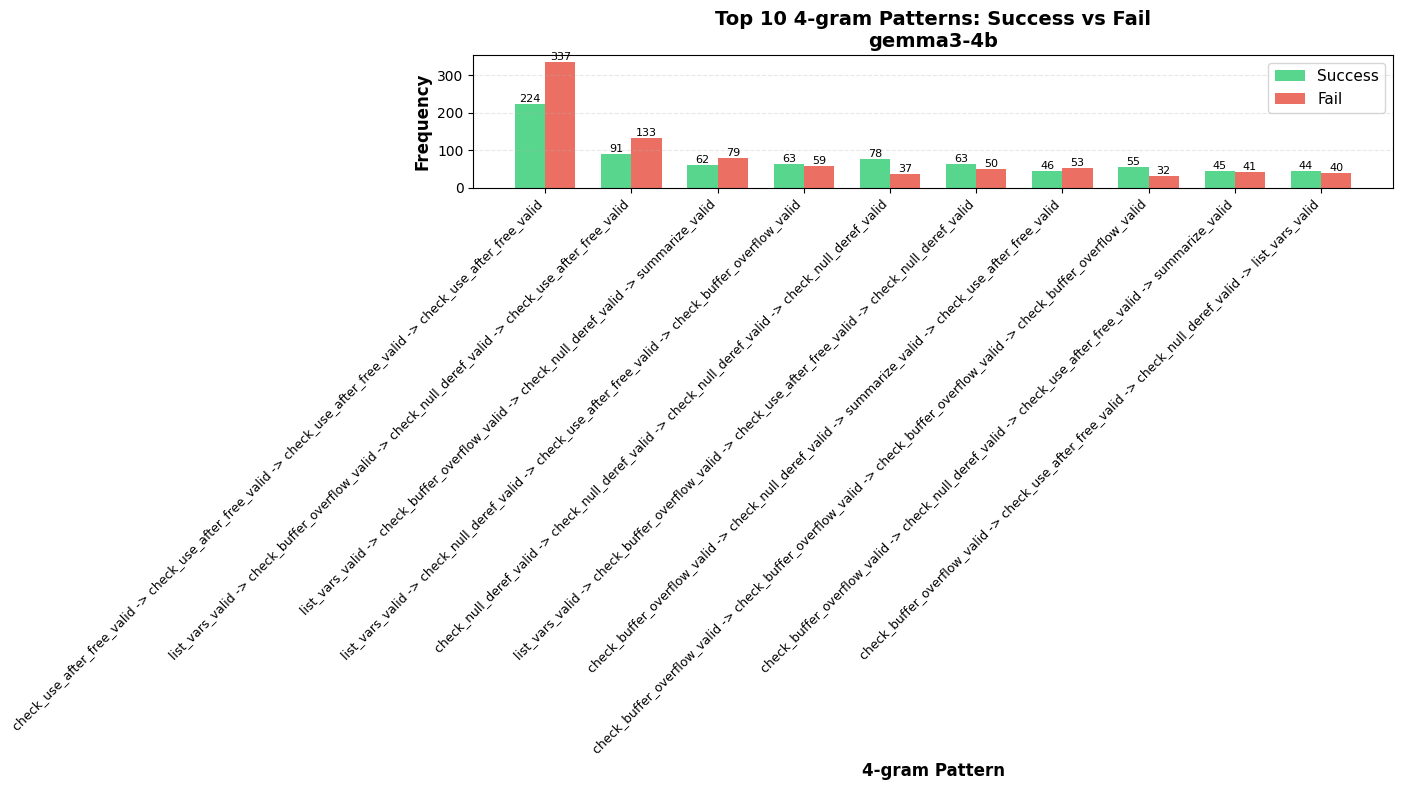


Model: llama3_1-8b


Total 4-grams collected: 60359

Total 4-grams collected: 29563

Total 4-grams collected: 30796
                                                                                                                 pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
check_buffer_overflow_valid -> check_buffer_overflow_valid -> check_buffer_overflow_valid -> check_buffer_overflow_valid             656                 362              294         55.2%      44.8%
                                   check_buffer_overflow_valid -> summarize_valid -> list_vars_valid -> list_funcs_valid             565                 267              298         47.3%      52.7%
                    check_null_deref_valid -> check_null_deref_valid -> check_null_deref_valid -> check_null_deref_valid             537                 336              201         62.6%      37.4%
                             check_buffer_overflow_valid -> check_null_deref_valid -> s

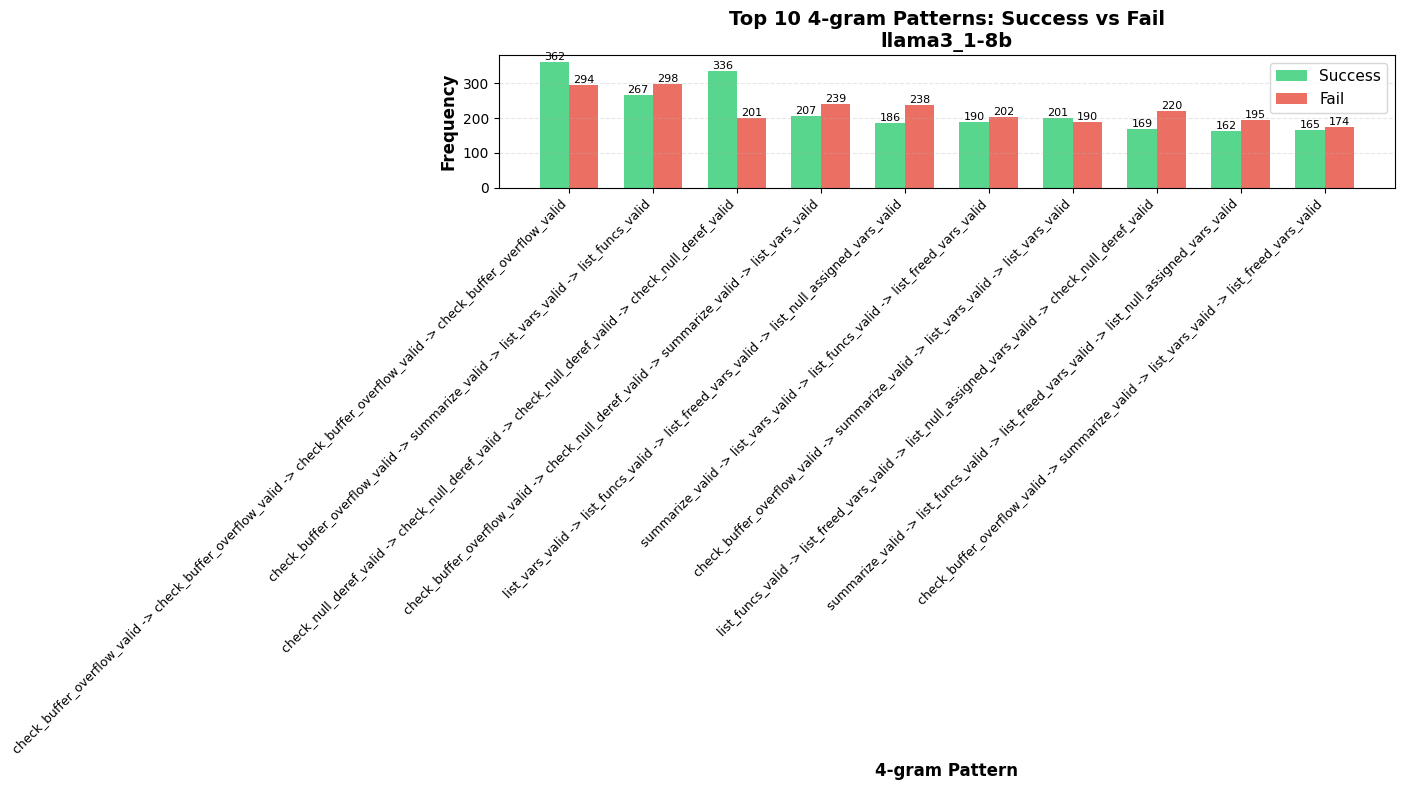


Model: llama3_2-3b


Total 4-grams collected: 25771

Total 4-grams collected: 11643

Total 4-grams collected: 14128
                                                                                               pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
check_buffer_overflow_valid -> list_vars_valid -> check_use_after_free_valid -> check_null_deref_valid             255                 129              126         50.6%      49.4%
list_vars_valid -> check_buffer_overflow_valid -> check_use_after_free_valid -> check_null_deref_valid             253                 107              146         42.3%      57.7%
list_vars_valid -> check_buffer_overflow_valid -> check_null_deref_valid -> check_use_after_free_valid             241                 117              124         48.5%      51.5%
check_buffer_overflow_valid -> list_vars_valid -> check_null_deref_valid -> check_use_after_free_valid             234                 105              129    

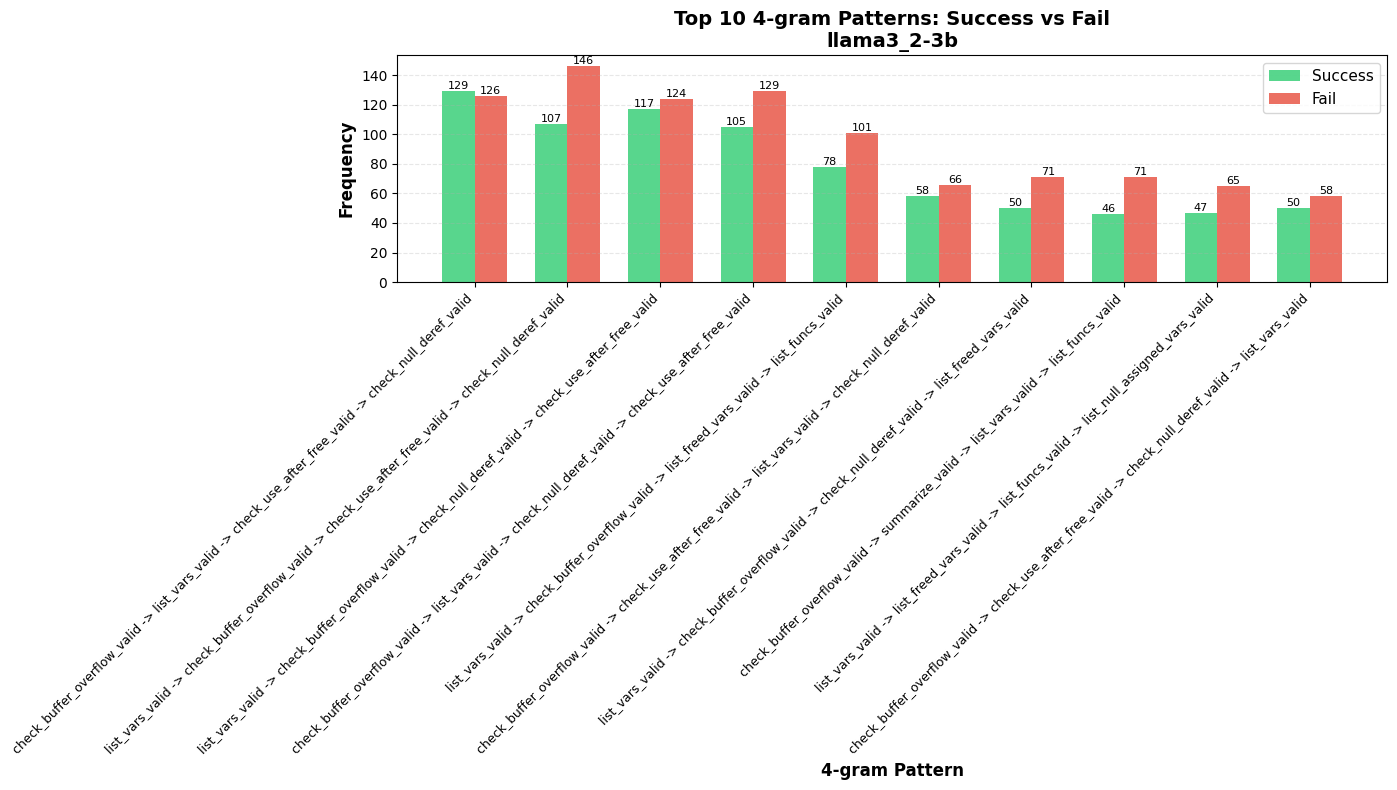


Model: mistral-7b


Total 4-grams collected: 64828

Total 4-grams collected: 33639

Total 4-grams collected: 31189
                                                                                                                   pattern  all_executions  success_executions  fail_executions success_ratio fail_ratio
  check_buffer_overflow_valid -> check_buffer_overflow_valid -> check_buffer_overflow_valid -> check_buffer_overflow_valid           11580                6321             5259         54.6%      45.4%
                                                  list_vars_valid -> list_vars_valid -> list_vars_valid -> list_vars_valid            2756                1475             1281         53.5%      46.5%
      check_use_after_free_valid -> check_use_after_free_valid -> check_use_after_free_valid -> check_use_after_free_valid            2568                1341             1227         52.2%      47.8%
              list_vars_valid -> check_buffer_overflow_valid -> check_buffer_ove

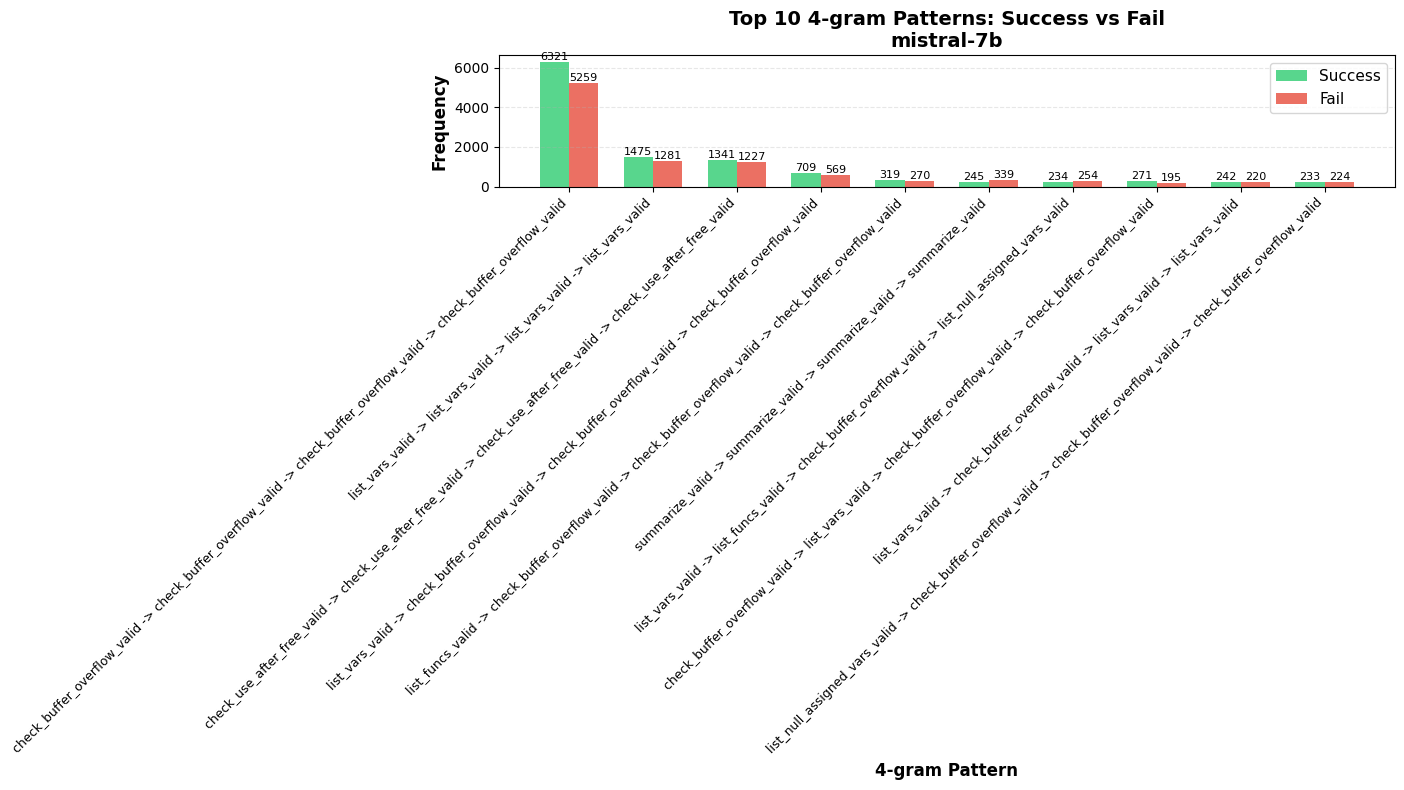

In [96]:
# Compare top 10 most frequent 4-grams in all executions vs success/fail executions

import matplotlib.pyplot as plt
import numpy as np

name_mapping = {
    "summarize_code()_valid": "summarize_valid",
    "list_variables()_valid": "list_vars_valid",
    "list_functions()_valid": "list_funcs_valid",
    "list_freed_variables()_valid": "list_freed_vars_valid",
    "list_null_assigned_variables()_valid": "list_null_assigned_vars_valid",
    "check_pattern(buffer_overflow)_valid": "check_buffer_overflow_valid",
    "check_pattern(null_deref)_valid": "check_null_deref_valid",
    "check_pattern(use_after_free)_valid": "check_use_after_free_valid",
    "summarize_code()_invalid": "summarize_invalid",
    "list_variables()_invalid": "list_vars_invalid",
    "list_functions()_invalid": "list_funcs_invalid",
    "list_freed_variables()_invalid": "list_freed_vars_invalid",
    "list_null_assigned_variables()_invalid": "list_null_assigned_vars_invalid",
    "check_pattern(buffer_overflow)_invalid": "check_buffer_overflow_invalid",
    "check_pattern(null_deref)_invalid": "check_null_deref_invalid",
    "check_pattern(use_after_free)_invalid": "check_use_after_free_invalid",
}


def shorten_pattern(pattern_tuple):
    """Convert long function names to short versions"""
    return ' -> '.join([name_mapping.get(func, func) for func in pattern_tuple])

# For each benchmark and model combination
models = ['gemma3-4b', 'llama3_1-8b', 'llama3_2-3b', 'mistral-7b']

for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_4grams = get_4grams_for_all_executions(model, with_validity=True)
    success_4grams = get_4grams_for_success_executions(model, with_validity=True)
    fail_4grams = get_4grams_for_fail_executions(model, with_validity=True)
    
    all_counter = Counter(all_4grams)
    success_counter = Counter(success_4grams)
    fail_counter = Counter(fail_4grams)
    
    # Get top 10 from all executions
    top_10_patterns = [pattern for pattern, count in all_counter.most_common(10)]
    
    # Create comparison table
    comparison_data = []
    for pattern in top_10_patterns:
        all_count = all_counter[pattern]
        success_count = success_counter[pattern]
        fail_count = fail_counter[pattern]
        
        comparison_data.append({
            'pattern': shorten_pattern(pattern),
            'all_executions': all_count,
            'success_executions': success_count,
            'fail_executions': fail_count,
            'success_ratio': f"{success_count/all_count*100:.1f}%" if all_count > 0 else "0%",
            'fail_ratio': f"{fail_count/all_count*100:.1f}%" if all_count > 0 else "0%"
        })
    
    # Display as DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print()
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    patterns = comparison_df['pattern'].tolist()
    success_counts = comparison_df['success_executions'].tolist()
    fail_counts = comparison_df['fail_executions'].tolist()
    
    x = np.arange(len(patterns))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, success_counts, width, label='Success', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, fail_counts, width, label='Fail', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('4-gram Pattern', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 10 4-gram Patterns: Success vs Fail\n{model}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(patterns, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


Model: gemma3-4b


Total 4-grams collected: 3762

Total 4-grams collected: 1692

Total 4-grams collected: 2070


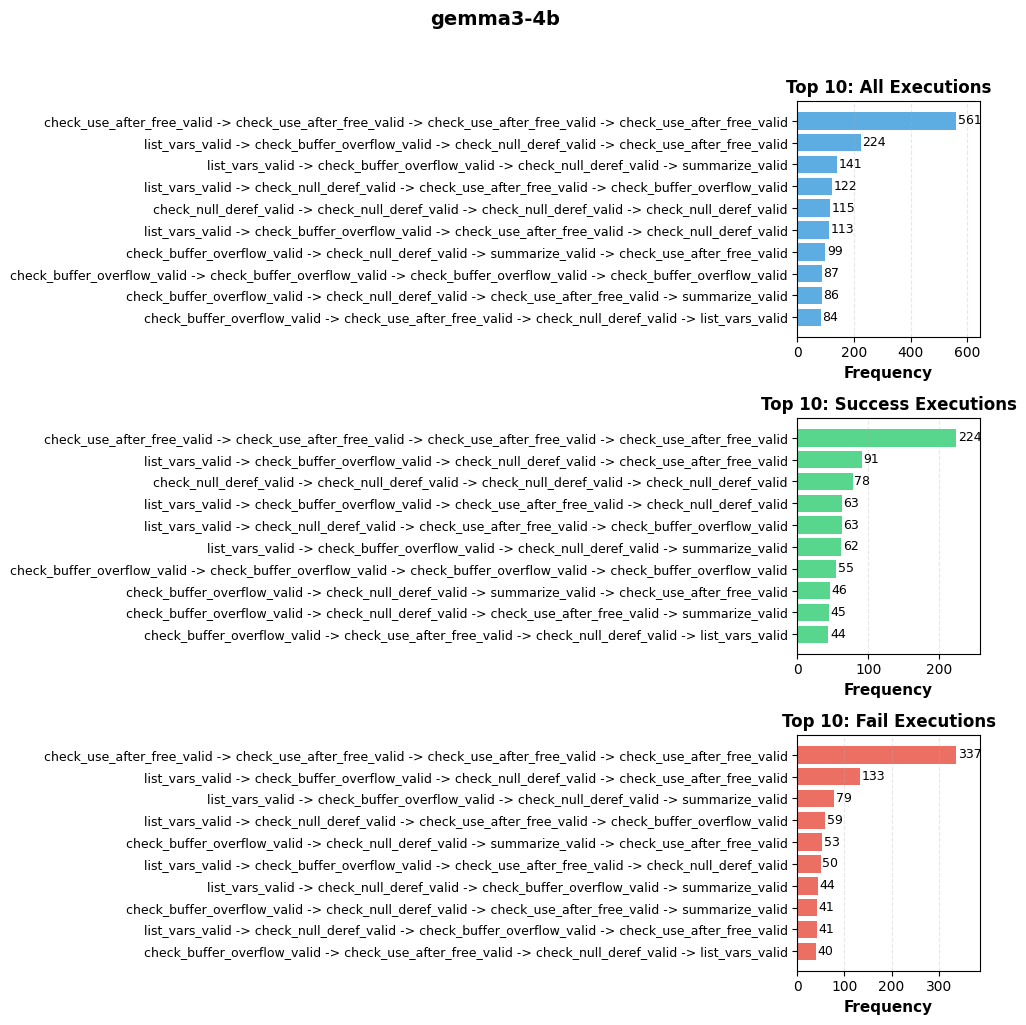


Model: llama3_1-8b


Total 4-grams collected: 60359

Total 4-grams collected: 29563

Total 4-grams collected: 30796


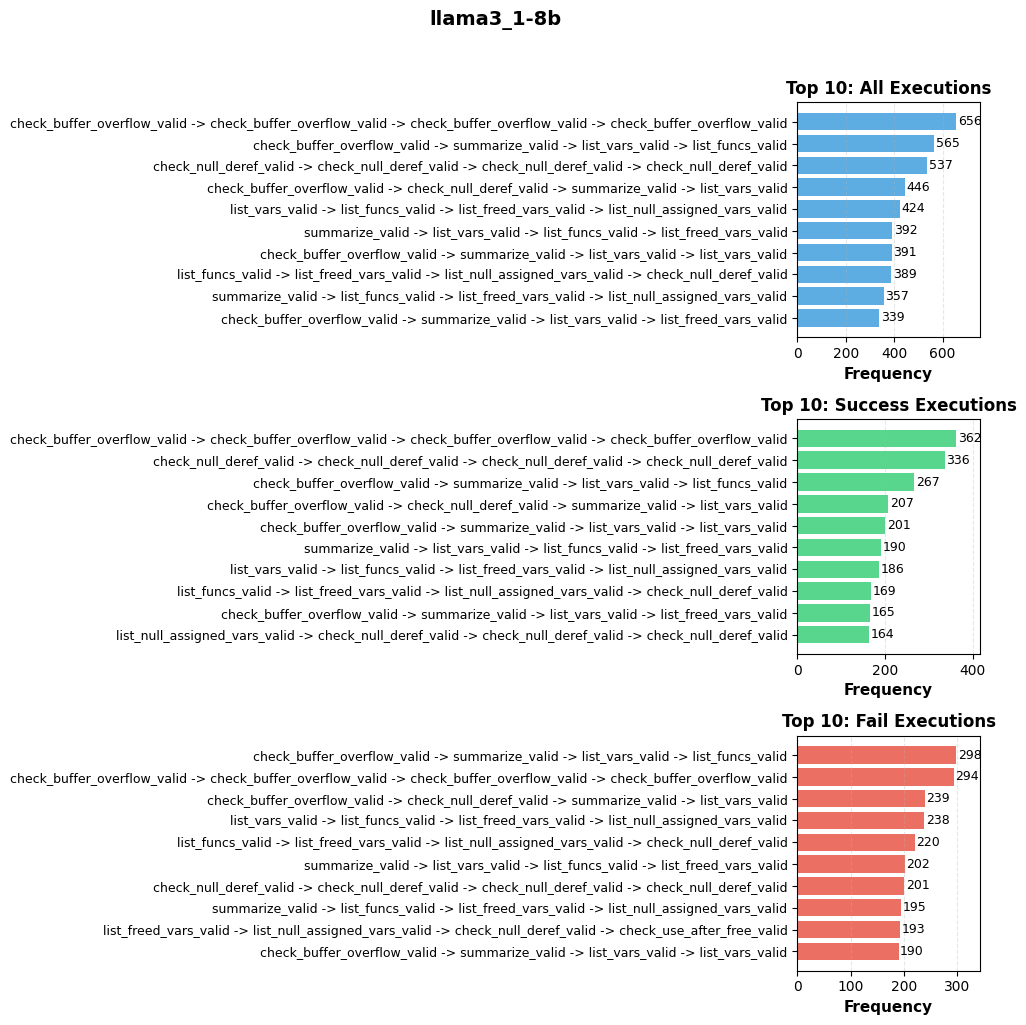


Model: llama3_2-3b


Total 4-grams collected: 25771

Total 4-grams collected: 11643

Total 4-grams collected: 14128


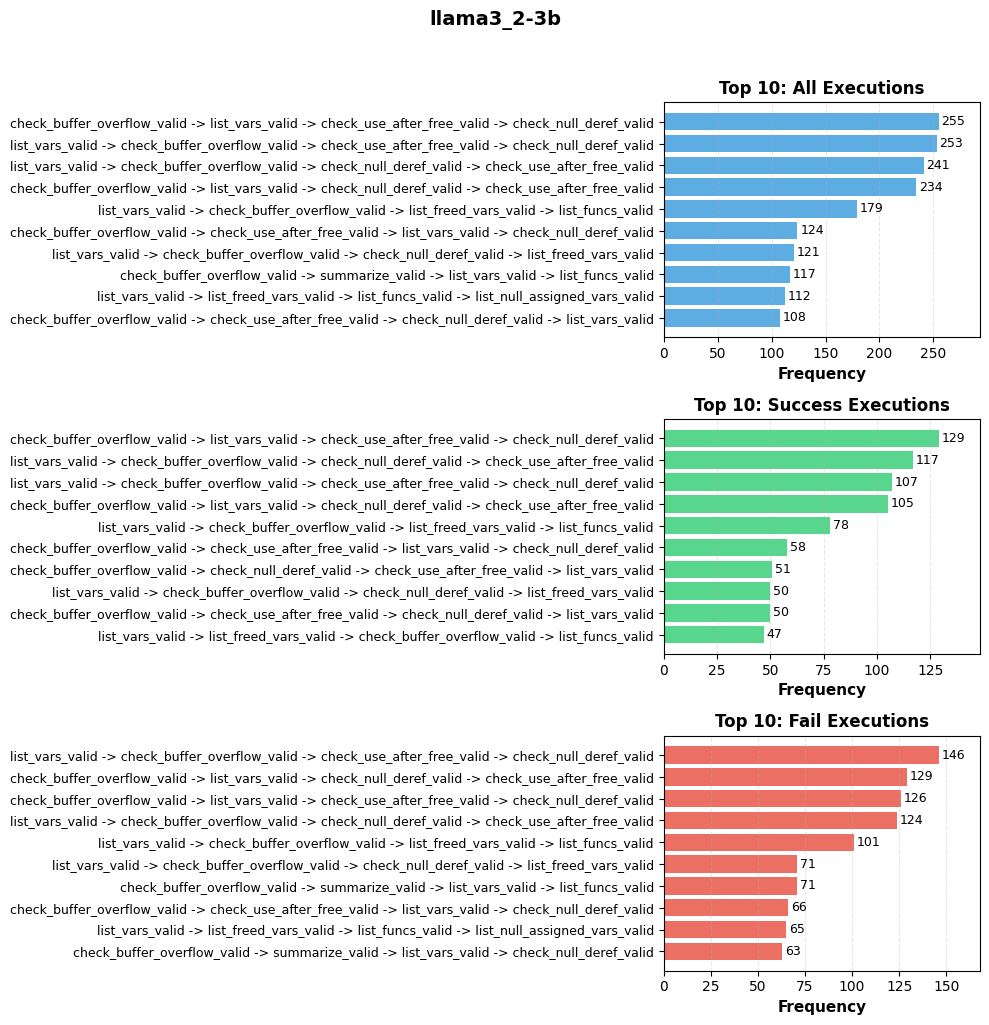


Model: mistral-7b


Total 4-grams collected: 64828

Total 4-grams collected: 33639

Total 4-grams collected: 31189


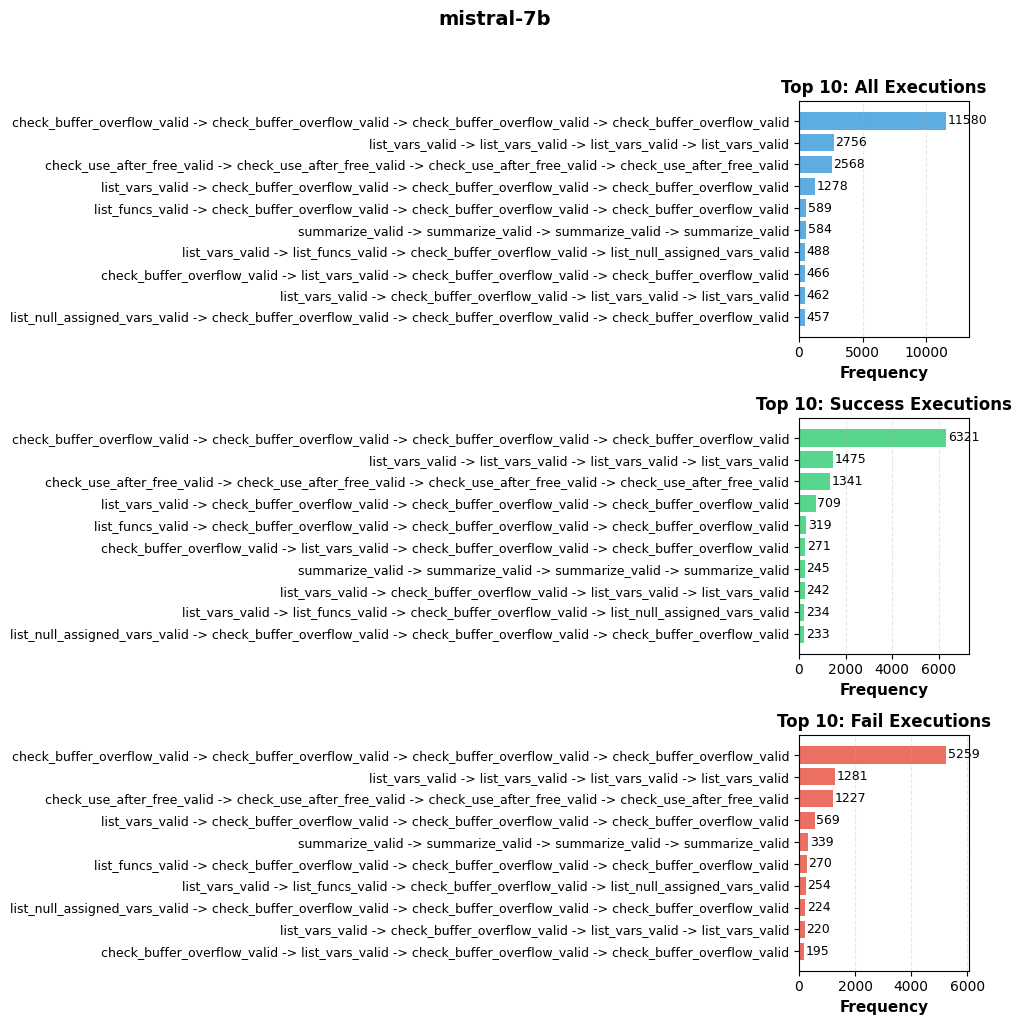

In [97]:
# Visualize Top 10 patterns separately for all/success/fail executions


for model in models:
    print(f"\n{'='*100}")
    print(f"Model: {model}")
    print(f"{'='*100}\n")
    
    # Load the three counters
    all_4grams = get_4grams_for_all_executions(model, with_validity=True)
    success_4grams = get_4grams_for_success_executions(model, with_validity=True)
    fail_4grams = get_4grams_for_fail_executions(model, with_validity=True)
    
    all_counter = Counter(all_4grams)
    success_counter = Counter(success_4grams)
    fail_counter = Counter(fail_4grams)
    
    # Get top 10 from each counter
    top_10_all = [(shorten_pattern(pattern), count) for pattern, count in all_counter.most_common(10)]
    top_10_success = [(shorten_pattern(pattern), count) for pattern, count in success_counter.most_common(10)]
    top_10_fail = [(shorten_pattern(pattern), count) for pattern, count in fail_counter.most_common(10)]
    
    # Create 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))
    
    # Plot 1: All Executions
    patterns_all = [p[0] for p in top_10_all]
    counts_all = [p[1] for p in top_10_all]
    
    axes[0].barh(range(len(patterns_all)), counts_all, color='#3498db', alpha=0.8)
    axes[0].set_yticks(range(len(patterns_all)))
    axes[0].set_yticklabels(patterns_all, fontsize=9)
    axes[0].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title('Top 10: All Executions', fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3, linestyle='--')

    axes[0].set_xlim(0, max(counts_all)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_all):
        axes[0].text(v + max(counts_all)*0.01, i, str(v), va='center', fontsize=9)
    
    # Plot 2: Success Executions
    patterns_success = [p[0] for p in top_10_success]
    counts_success = [p[1] for p in top_10_success]
    
    axes[1].barh(range(len(patterns_success)), counts_success, color='#2ecc71', alpha=0.8)
    axes[1].set_yticks(range(len(patterns_success)))
    axes[1].set_yticklabels(patterns_success, fontsize=9)
    axes[1].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('Top 10: Success Executions', fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')

    axes[1].set_xlim(0, max(counts_success)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_success):
        axes[1].text(v + max(counts_success)*0.01, i, str(v), va='center', fontsize=9)
    
    # Plot 3: Fail Executions
    patterns_fail = [p[0] for p in top_10_fail]
    counts_fail = [p[1] for p in top_10_fail]
    
    axes[2].barh(range(len(patterns_fail)), counts_fail, color='#e74c3c', alpha=0.8)
    axes[2].set_yticks(range(len(patterns_fail)))
    axes[2].set_yticklabels(patterns_fail, fontsize=9)
    axes[2].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[2].set_title('Top 10: Fail Executions', fontsize=12, fontweight='bold')
    axes[2].invert_yaxis()
    axes[2].grid(axis='x', alpha=0.3, linestyle='--')

    axes[2].set_xlim(0, max(counts_fail)*1.15)
    
    # Add value labels
    for i, v in enumerate(counts_fail):
        axes[2].text(v + max(counts_fail)*0.01, i, str(v), va='center', fontsize=9)
    
    # Overall title
    fig.suptitle(f'{model}', fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()